In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,classification_report
from mlxtend.plotting import plot_confusion_matrix 
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from random import shuffle
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50


path = '/content/drive/MyDrive/fer2013.csv'
df = pd.read_csv(path)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data = df.drop('Usage', axis = 1)

In [ ]:
data.pixels = data.pixels.apply(lambda x : list(map(lambda i: int(i), x.split(' '))))

In [ ]:
data.pixels = data.pixels.apply(lambda x: np.array(x))

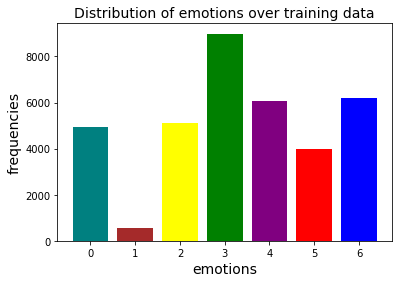

In [ ]:
emotions = data['emotion'].value_counts().to_frame().index.tolist()
emotion_frequencies=data['emotion'].value_counts().values
colors = ['green','blue','purple','yellow','teal','red','brown']
plt.bar(emotions, emotion_frequencies, color=colors)
plt.title('Distribution of emotions over training data', fontsize=14)
plt.xlabel('emotions', fontsize=14)
plt.ylabel('frequencies', fontsize=14)
plt.show()

In [ ]:
def data_augmentation(pic_array, emotion, times):
    generated_pics=[]
    n_pic = pic_array.reshape((48,48,1))
    # expand dimension to one sample
    samples = expand_dims(n_pic, 0)
    # create image data augmentation generator

    # horizontal and vertical shift
    datagen1 = ImageDataGenerator(width_shift_range=[-15,15])
    datagen2 = ImageDataGenerator(height_shift_range=0.4)
    
    # horizontal flip
    datagen3 = ImageDataGenerator(horizontal_flip=True)
    
    # random rotation
    datagen4 = ImageDataGenerator(rotation_range=90)
    
    # random zoom 
    datagen5 = ImageDataGenerator(zoom_range=[0.5,1.0])
    

    generators = [datagen3,datagen4,datagen5,datagen1,datagen2]
    l = []
    # prepare iterator
    for i in range(len(generators)):
      l.append(generators[i].flow(samples, batch_size=1))


    it = times % 5
    times = times//5 
    # generate samples and plot
    for i in range(times):
        # define subplt
        #pyplot.subplot(330 + 1 + i)
      for i in range(len(l)):
        g = l[i].next()
        image = g[0].astype('uint8')
        arr = image.reshape((48*48))
        generated_pics.append([arr,emotion])
        # plot raw pixel data
        #print(image5.shape)
        #plt.imshow(image5.reshape(48,48), cmap = 'gray')
    for i in range(it): 
      g = l[i].next()
      image = g[0].astype('uint8')
      arr = image.reshape((48*48))
      generated_pics.append([arr,emotion])
        
    
    # show the figure
    #pyplot.show()
    return generated_pics

In [ ]:

# list_data = []
# for i in range(0,len(data)):
#   list_data.append([data.loc[i]['pixels'], data.loc[i]['emotion']])
# shuffle(list_data)


list_data = []
times_d = {0:2, 1:15, 2:2,3:1,4:1,5:2,6:1}
for i in range(0,len(data)):
    list_data.append([data.loc[i]['pixels'], data.loc[i]['emotion']])
    emotion = data.loc[i]['emotion']
    pic_array = data.loc[i]['pixels']
    gen_pics = data_augmentation(pic_array, emotion,times_d[emotion])
    list_data.extend(gen_pics)
    
   
shuffle(list_data)

In [ ]:
emotions = []
for i in list_data: 
  emotions.append(i[1])
emotion_frequencies = [0,0,0,0,0,0,0]
for i in emotions: 
  emotion_frequencies[i]+=1
print(emotion_frequencies)
counts = range(7)

[14859, 8752, 15363, 17978, 12154, 12006, 12396]


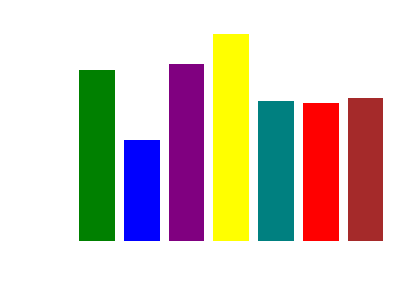

In [ ]:
color = 'black'
with plt.rc_context({'axes.edgecolor':color, 'xtick.color':color, 'ytick.color':color}):
  colors = ['green','blue','purple','yellow','teal','red','brown']
  plt.bar(counts, emotion_frequencies, color=colors)
  plt.title('Distribution of emotions over training data', fontsize=14,color = color)
  plt.xlabel('emotions', fontsize=14,color = color)
  plt.ylabel('frequencies', fontsize=14,color = color)
  plt.show()

In [ ]:

X = np.array([i[0] for i in list_data])
X = X.reshape(-1,48,48,1)
y = np.array([i[1] for i in list_data])

In [ ]:

X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=0.8)

y_train = np_utils.to_categorical(y_train)

# Functions to Test the Model

In [ ]:
def getAccuracy(X_test,y_test):
  y_pred_vec = model.predict(X_test)
  y_pred = np.argmax(y_pred_vec, axis = 1)
  return accuracy_score(y_test, y_pred)

In [ ]:
def plotAccuracy(train_acc,val_acc,color,ep): 
  epochs=range(1,ep+1)
  with plt.rc_context({'axes.edgecolor':color, 'xtick.color':color, 'ytick.color':color}):
    plt.plot(epochs,train_acc,label="Train Accuracy")
    plt.plot(epochs,val_acc,label="Validation Accuracy")
    plt.title("Accuracy vs Epochs", color = color)
    plt.xlabel("Epochs", color = color)
    plt.ylabel("Accuracy", color = color)
    plt.legend()
    plt.show()

In [ ]:
def plotLoss(train_loss,val_loss,color,ep):
  epochs=range(1,ep+1)

  with plt.rc_context({'axes.edgecolor':color, 'xtick.color':color, 'ytick.color':color}):
    plt.plot(epochs,train_loss,label="Train Loss")
    plt.plot(epochs,val_loss,label="Validation Loss")
    plt.title("Loss vs Epochs", color = color)
    plt.xlabel("Epochs", color = color)
    plt.ylabel("Loss", color = color)
    plt.legend()
    plt.show()

In [ ]:
def evaluate(X_test,actual,model):
    y_pred_vec = model.predict(X_test)
    pred = np.argmax(y_pred_vec, axis = 1)
    cm=confusion_matrix(pred,actual)
    fig, ax = plot_confusion_matrix(conf_mat=cm, cmap=plt.cm.OrRd)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    
    f1=f1_score(pred,actual,average='weighted')
    cr=classification_report(actual, pred, output_dict= True)
    accuracy = cr['accuracy']
    del cr['accuracy']
    cr_df = pd.DataFrame(cr).transpose()
    plt.show() 
    print("F1 Score :",f1)
    print("Classification Report")
    print(cr_df)

#DropOut 

In [ ]:
model = keras.Sequential()
output_layers = [Conv2D(32, 3,activation='relu', padding ='same', input_shape=(48,48,1)),
                 Conv2D(64, 3, activation='relu', padding ='same'),MaxPooling2D(2, padding ='same'),Dropout(0.5),
                 Conv2D(128, 3, activation='relu', padding ='same'),MaxPooling2D(2, padding ='same'),Dropout(0.5),
                 Conv2D(256, 3, activation='relu', padding ='same'),MaxPooling2D(2, padding ='same'),Dropout(0.5),
                 Conv2D(512, 3, activation='relu', padding ='same'),MaxPooling2D(2, padding ='same'),Dropout(0.5),
                 Flatten(),Dense(1024, activation = 'relu'),Dense(256, activation = 'relu'),Dense(7, activation = 'softmax')]
]
for i in output_layers:
  model.add(i)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                    

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
epochs = 55
l=model.fit(X_train, y_train, epochs = epochs, batch_size= 64,validation_split=0.2)

Epoch 1/5
936/936 [==============================] - 65s 69ms/step - loss: 1.0213 - accuracy: 0.6193 - val_loss: 1.0123 - val_accuracy: 0.6213
Epoch 2/5
936/936 [==============================] - 64s 68ms/step - loss: 1.0169 - accuracy: 0.6186 - val_loss: 1.0056 - val_accuracy: 0.6221
Epoch 3/5
936/936 [==============================] - 64s 68ms/step - loss: 1.0085 - accuracy: 0.6237 - val_loss: 1.0414 - val_accuracy: 0.6187
Epoch 4/5
936/936 [==============================] - 63s 68ms/step - loss: 1.0254 - accuracy: 0.6186 - val_loss: 1.0469 - val_accuracy: 0.6074
Epoch 5/5
936/936 [==============================] - 64s 69ms/step - loss: 0.9897 - accuracy: 0.6311 - val_loss: 1.0339 - val_accuracy: 0.6113


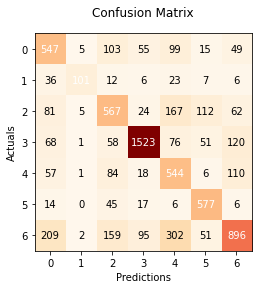

F1 Score : 0.6656882635436148
Classification Report
              precision    recall  f1-score  support
0              0.626575  0.540514  0.580371   1012.0
1              0.528796  0.878261  0.660131    115.0
2              0.556974  0.551556  0.554252   1028.0
3              0.802847  0.876295  0.837964   1738.0
4              0.663415  0.447001  0.534119   1217.0
5              0.867669  0.704518  0.777628    819.0
6              0.522754  0.717374  0.604792   1249.0
macro avg      0.652718  0.673645  0.649894   7178.0
weighted avg   0.673410  0.662441  0.659193   7178.0


In [ ]:
acc = getAccuracy(X_test,y_test)
color = 'black'
print(acc)
plotAccuracy(l.history['accuracy'],l.history['val_accuracy'],color,epochs)
plotLoss(l.history['loss'],l.history['val_loss'],color,epochs)
evaluate(X_test ,y_test,model)

#Tranfer Learning

In [ ]:
X = np.array([i[0] for i in list_data])
y = np.array([i[1] for i in list_data])
X=np.array([[i,i,i] for i in X])
X = X.reshape(-1,48,48,3)
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=0.8)

y_train = np_utils.to_categorical(y_train)

In [ ]:

model = keras.Sequential()
res50model = ResNet50(include_top = False, input_shape=(48,48,3),classes = 7 ,weights='imagenet')
output_layers = [Flatten(),Dense(128, activation = 'relu'),Dense(32, activation = 'relu'),Dense(7, activation = 'softmax')]
model.add(res50model)
for i in output_layers:
  model.add(i)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
epochs = 25
l=model.fit(X_train, y_train, epochs = epochs, batch_size= 64,validation_split=0.2)

In [ ]:
acc = getAccuracy(X_test,y_test)
color = 'black'
print(acc)
plotAccuracy(l.history['accuracy'],l.history['val_accuracy'],color,epochs)
plotLoss(l.history['loss'],l.history['val_loss'],color,epochs)
evaluate(X_test ,y_test,model)

#Batch Norm

In [ ]:
model = keras.Sequential()
output_layers = [Conv2D(32, 3,activation='relu', padding ='same', input_shape=(48,48,1)),Conv2D(64, 3, activation='relu', padding ='same'),MaxPooling2D(2, padding ='same'),BatchNormalization(),
                 Conv2D(128, 3, activation='relu', padding ='same'),MaxPooling2D(2, padding ='same'),BatchNormalization(),
                 Conv2D(256, 3, activation='relu', padding ='same'),MaxPooling2D(2, padding ='same'),BatchNormalization(),
                 Conv2D(512, 3, activation='relu', padding ='same'),MaxPooling2D(2, padding ='same'),BatchNormalization(),
                 Flatten(),Dense(1024, activation = 'relu'),Dense(256, activation = 'relu'),Dense(7, activation = 'softmax')]
# model.add(res50model)
for i in output_layers:
  model.add(i)
model.summary()


In [ ]:
y_pred_vec = model.predict(X_test)
y_pred = np.argmax(y_pred_vec, axis = 1)
accuracy_score(y_test, y_pred)